In [1]:
import torch
import numpy as np

from models.experimental import attempt_load
from utils.datasets import letterbox

import cv2
import torch
import numpy as np

from utils.general import non_max_suppression, scale_coords
from utils.torch_utils import select_device

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

/home/alijakhar/anaconda3/envs/yolov7/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def load_model(device,weights,imgsz):
        # device= 'cuda:0' #for cpu-> 'cpu'
    half = device.type != 'cpu'

    model = attempt_load(weights, map_location=device)
    stride = int(model.stride.max())  # model stride

    if half:
        model.half()  # to FP16

    names = model.module.names if hasattr(model, 'module') else model.names

    ###### infrence ####
    if device.type != 'cpu':
        model(torch.zeros(1, 3, imgsz, imgsz).to(device).type_as(next(model.parameters())))  # run once
        old_img_w = old_img_h = imgsz
        old_img_b = 1

    return stride, model, names, half ,old_img_w,old_img_h, old_img_b

def img_preprocessing(frame, imgsz, stride, device, half):
    img = letterbox(frame, imgsz, stride=stride)[0]
    # Convert
    img = img[:, :, ::-1].transpose(2, 0, 1)  # BGR to RGB, to 3x416x416
    img = np.ascontiguousarray(img)

    img = torch.from_numpy(img).to(device)
    img = img.half() if half else img.float()  # uint8 to fp16/32
    img /= 255.0  # 0 - 255 to 0.0 - 1.0
    if img.ndimension() == 3:
        img = img.unsqueeze(0)
    
    return img

In [3]:
imgsz = 640
conf_thres = 0.70 #### threshold value
iou_thres = 0.45

weights = "../runs/train/yolov7-custom/weights/best.pt"
imgsz = 640
conf_thres = 0.1
iou_thres = 0.45
device = select_device('0')
print(device)
### load yolov7 model ###
stride, model, names, half, old_img_w,old_img_h, old_img_b = load_model(device,weights,imgsz)

classes=['pale_yellow_durain','bright_yellow_durain','light_red_durain']
colors=[(0,255,255),(255,255,0),(255,51,255)]

cuda:0
Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse


/home/alijakhar/anaconda3/envs/yolov7/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [4]:
def model_predictor(frame):
    alpha=0.3
    global old_img_b, old_img_h, old_img_w
    tl = 3 or round(0.002 * (img.shape[0] + frame.shape[1]) / 2) + 1  # line/font thickness
    tf = max(tl - 1, 1)


    img = img_preprocessing(frame, imgsz, stride, device, half)

    ### Prediction
    if device.type != 'cpu' and (old_img_b != img.shape[0] or old_img_h != img.shape[2] or old_img_w != img.shape[3]):
        old_img_b = img.shape[0]
        old_img_h = img.shape[2]
        old_img_w = img.shape[3]
        for i in range(3):
            model(img)[0]

    with torch.no_grad():   # Calculating gradients would cause a GPU memory leak
        pred = model(img)[0]
    pred = non_max_suppression(pred, conf_thres, iou_thres, classes=None, agnostic=False) #Apply NMS
    # Process detections
    for i, det in enumerate(pred):
        if len(det):
            bboxes=[]
            pred_classes=[]
            pred_scores=[]
            det[:, :4] = scale_coords(img.shape[2:], det[:, :4], frame.shape).round()

            for *xyxy, conf, cls in reversed(det):
                x1,y1,x2,y2 = int(xyxy[0]), int(xyxy[1]), int(xyxy[2]), int(xyxy[3])
                pred_class = (int(cls))
                pred_scores = round(float(conf), 2)
                cv2.rectangle(frame, (x1,y1), (x2,y2), colors[pred_class], tl, lineType=cv2.LINE_AA)
                cv2.putText(frame,classes[pred_class],(x1,y1-2),0,tl / 3,(255,255,255),thickness=tf, lineType=cv2.LINE_AA)
                cv2.putText(frame,str(pred_scores),(x2,y1-2),0,tl / 3,(255,255,255),thickness=tf, lineType=cv2.LINE_AA)
    return frame

In [5]:

test_img_path="../Durain_annotated_dataset/val/images/red-durian-borneo-sabah-travel-guide.jpg"
###read image
image= cv2.imread(test_img_path)
pred_img=model_predictor(image)

cv2.imwrite("../predicted_results/predicted_image.jpg",pred_img)
# plt.imshow(pred_img)
# plt.axis('off') # To not display the axes
# plt.show()


True

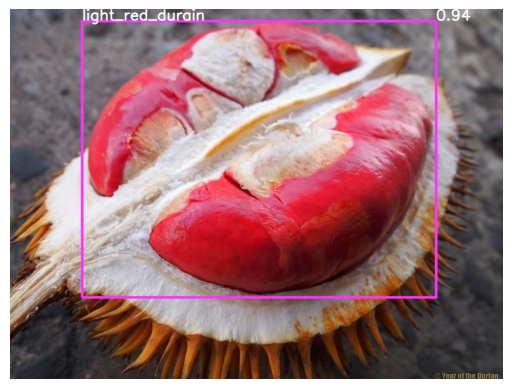

In [7]:
%matplotlib inline
image_path = '../predicted_results/predicted_image.jpg'

img = mpimg.imread(image_path)

plt.imshow(img)
plt.axis('off')
plt.show()